In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
np.random.seed(0)

In [3]:
num_steps = 4000
num_states = 30

In [4]:
# Right-biased 1D Walk
dset = inputs.Sim1DWalk(
    num_steps=num_steps, left_right_stay_prob=[1, 1, 1.5],
    num_states=num_states
    )

In [5]:
# Set up network
save_path = '../trained_models/baseline/'
model_path = save_path + 'model.pt'
net_configs_path = save_path + 'net_configs.p'
with open(net_configs_path, 'rb') as f:
    net_configs = pickle.load(f)
net_configs.pop('num_states')
net = STDP_SR(num_states=num_states, **net_configs)
net.load_state_dict(torch.load(model_path))
net.ca3.set_differentiability(False)

In [6]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
input_states = []
for t in range(dg_inputs.shape[0]):
    input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
input_states = np.array(input_states)

In [7]:
# Get lap start indices
lap_starts = [0]
state_counts = np.zeros(num_states)
for t, input_state in enumerate(input_states):
    if not np.any(state_counts == 0):
        lap_starts.append(t)
        state_counts = np.zeros(num_states)
    state_counts[input_state] += 1
lap_starts = np.array(lap_starts)

# Run network

In [8]:
Ms = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    curr_dg_mode = dg_modes[step].unsqueeze(0)
    reset = True if step == 0 else False
    _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
    if step in lap_starts:
        Ms.append(net.get_M(0.95))

# Plot place field induction laps

In [9]:
for state in np.unique(input_states):
    first_t = np.argwhere(input_states == state)[0,0]
    print(f'State {state} first encountered in {first_t}')

State 0 first encountered in 0
State 1 first encountered in 1
State 2 first encountered in 2
State 3 first encountered in 5
State 4 first encountered in 7
State 5 first encountered in 8
State 6 first encountered in 10
State 7 first encountered in 13
State 8 first encountered in 20
State 9 first encountered in 21
State 10 first encountered in 23
State 11 first encountered in 36
State 12 first encountered in 37
State 13 first encountered in 38
State 14 first encountered in 39
State 15 first encountered in 42
State 16 first encountered in 45
State 17 first encountered in 117
State 18 first encountered in 118
State 19 first encountered in 119
State 20 first encountered in 120
State 21 first encountered in 122
State 22 first encountered in 123
State 23 first encountered in 125
State 24 first encountered in 130
State 25 first encountered in 136
State 26 first encountered in 137
State 27 first encountered in 138
State 28 first encountered in 140
State 29 first encountered in 143


In [10]:
chosen_state = 19
num_laps = 16
M_vectors = [M[chosen_state,:].detach().numpy() for M in Ms]
M_vectors = np.array(M_vectors)

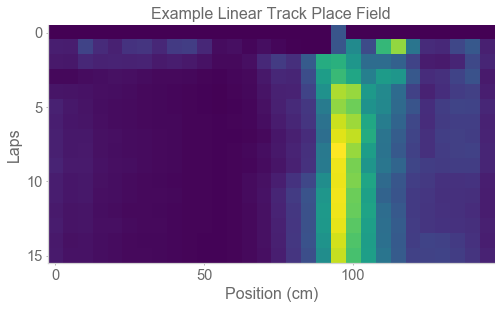

In [11]:
plt.figure(figsize=(8,5))
plt.imshow(M_vectors[:num_laps], cmap='viridis')
plt.yticks(np.arange(0, num_laps, 5))
plt.ylabel('Laps')
tick_locs = np.array([0, 50, 100]) # In cm
plt.xticks(tick_locs/configs.bin_to_cm, tick_locs)
plt.xlabel('Position (cm)')
plt.title(f'Example Linear Track Place Field')
plt.savefig('field_induction.png', dpi=200)
plt.show()